# Класифікація одягу (Fashion MNIST):

Імпортуємо необхідні бібліотеки

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

Перевіряємо, чи доступний GPU або MPS

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 
                      ("mps" if torch.backends.mps.is_available() else "cpu"))
print('Використовуємо пристрій:', device)

Використовуємо пристрій: mps


Визначаємо перетворення для попередньої обробки даних та завантажуємо датасети

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


Розбиваємо датасет на тренувальну та валідаційну вибірки

In [4]:
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Створюємо завантажувачі даних
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Для аналізу ми будемо створювати різні моделі : з одним, двома, трьома шарами, CNN та двома шарами та сигмоїдальною активацією

In [5]:
# Визначаємо модель з одним шаром
class OneLayerNN(nn.Module):
    def __init__(self):
        super(OneLayerNN, self).__init__()
        self.fc = nn.Linear(28*28, 10) 

    def forward(self, x):
        x = x.view(-1, 28*28)  
        x = self.fc(x)
        return x

# Визначаємо модель з двома шарами
class TwoLayerNN(nn.Module):
    def __init__(self):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Визначаємо модель з трьома шарами
class ThreeLayerNN(nn.Module):
    def __init__(self):
        super(ThreeLayerNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    # Визначаємо згорткову нейронну мережу (CNN)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),  
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  
            nn.Dropout(0.2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
# Визначаємо модель з двома шарами та сигмоїдальною активацією
class TwoLayerSigmoidNN(nn.Module):
    def __init__(self):
        super(TwoLayerSigmoidNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x


Функція тренування моделі

In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # Фаза тренування
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.float() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(val_loader.dataset)
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Функція оцінки моделі на тестовому наборі

In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    accuracy = correct.float() / len(test_loader.dataset)
    return accuracy.item()

Функція для відображення метрик тренування та валідації

In [8]:
def plot_metrics(epochs, train_loss, val_loss, train_acc, val_acc, model_name):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label='Тренувальна втрата')
    plt.plot(epochs, val_loss, label='Валідаційна втрата')
    plt.xlabel('Епохи')
    plt.ylabel('Втрата')
    plt.title(f'{model_name} - Втрата')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label='Тренувальна точність')
    plt.plot(epochs, val_acc, label='Валідаційна точність')
    plt.xlabel('Епохи')
    plt.ylabel('Точність')
    plt.title(f'{model_name} - Точність')
    plt.legend()

    plt.tight_layout()
    plt.show()

Функція для відображення матриці плутанини

In [9]:
def plot_confusion_matrix(model, test_loader, model_name):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds = torch.cat((all_preds.cpu(), preds.cpu()), dim=0)
            all_labels = torch.cat((all_labels.cpu(), labels.cpu()), dim=0)

    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_train_dataset.classes, yticklabels=full_train_dataset.classes)
    plt.xlabel('Передбачено')
    plt.ylabel('Справжнє')
    plt.title(f'Матриця плутанини - {model_name}')
    plt.show()

Функція для візуалізації передбачень

In [10]:
def visualize_predictions(model, test_loader, model_name, num_images=6):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 8))

    class_names = test_dataset.classes

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_shown == num_images:
                    break
                images_shown += 1
                plt.subplot(2, num_images//2, images_shown)
                plt.axis('off')
                plt.imshow(inputs.cpu().data[j].squeeze(), cmap='gray')
                plt.title(f'Передбачено: {class_names[preds[j]]}\nСправжнє: {class_names[labels[j]]}')

            if images_shown == num_images:
                break

    plt.suptitle(f'Приклади передбачень - {model_name}')
    plt.show()

Функція для візуалізації карт ознак

In [11]:
def visualize_feature_maps(model, test_loader, num_images=1):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)

            # Отримуємо карти ознак з першого згорткового шару
            x = inputs
            for layer in model.features[:1]: 
                x = layer(x)

            feature_maps = x.cpu().data

            for j in range(inputs.size()[0]):
                if images_shown == num_images:
                    break
                images_shown += 1
                plt.figure(figsize=(15, 15))
                for i in range(min(feature_maps.size(1), 16)):
                    plt.subplot(4, 4, i+1)
                    plt.imshow(feature_maps[j, i], cmap='gray')
                    plt.axis('off')
                plt.suptitle('Карти ознак з першого згорткового шару')
                plt.show()

            if images_shown == num_images:
                break

Тренування та оцінка моделі з одним шаром

In [12]:
model_one = OneLayerNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_one.parameters(), lr=0.001)

loss_one, val_loss_one, acc_one, val_acc_one = train_model(model_one, criterion, optimizer, train_loader, val_loader)
test_acc_one = evaluate_model(model_one, test_loader)
print(f'Точність на тестовому наборі для моделі з одним шаром: {test_acc_one:.4f}')

Epoch 1/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 119.92it/s]


Epoch 1/10, Train Loss: 0.5832, Train Acc: 0.7999, Val Loss: 0.4706, Val Acc: 0.8375


Epoch 2/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 110.07it/s]


Epoch 2/10, Train Loss: 0.4637, Train Acc: 0.8377, Val Loss: 0.4403, Val Acc: 0.8441


Epoch 3/10 - Training: 100%|██████████| 750/750 [00:07<00:00, 102.67it/s]


Epoch 3/10, Train Loss: 0.4434, Train Acc: 0.8450, Val Loss: 0.4385, Val Acc: 0.8452


Epoch 4/10 - Training: 100%|██████████| 750/750 [00:05<00:00, 133.39it/s]


Epoch 4/10, Train Loss: 0.4293, Train Acc: 0.8519, Val Loss: 0.4243, Val Acc: 0.8510


Epoch 5/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 115.22it/s]


Epoch 5/10, Train Loss: 0.4227, Train Acc: 0.8522, Val Loss: 0.4300, Val Acc: 0.8475


Epoch 6/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 116.49it/s]


Epoch 6/10, Train Loss: 0.4165, Train Acc: 0.8544, Val Loss: 0.4242, Val Acc: 0.8510


Epoch 7/10 - Training: 100%|██████████| 750/750 [00:05<00:00, 135.67it/s]


Epoch 7/10, Train Loss: 0.4107, Train Acc: 0.8562, Val Loss: 0.4288, Val Acc: 0.8454


Epoch 8/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 110.30it/s]


Epoch 8/10, Train Loss: 0.4086, Train Acc: 0.8562, Val Loss: 0.4355, Val Acc: 0.8470


Epoch 9/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 120.30it/s]


Epoch 9/10, Train Loss: 0.4054, Train Acc: 0.8571, Val Loss: 0.4226, Val Acc: 0.8540


Epoch 10/10 - Training: 100%|██████████| 750/750 [00:05<00:00, 140.37it/s]


Epoch 10/10, Train Loss: 0.3998, Train Acc: 0.8606, Val Loss: 0.4242, Val Acc: 0.8510
Точність на тестовому наборі для моделі з одним шаром: 0.8368


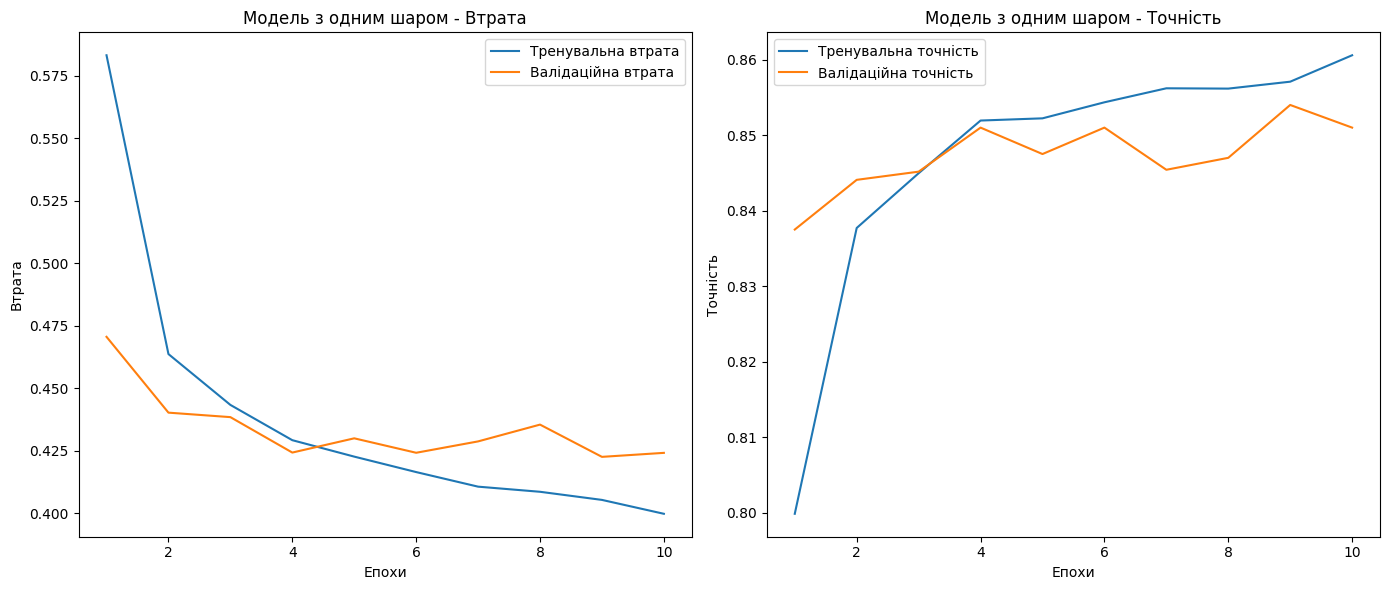

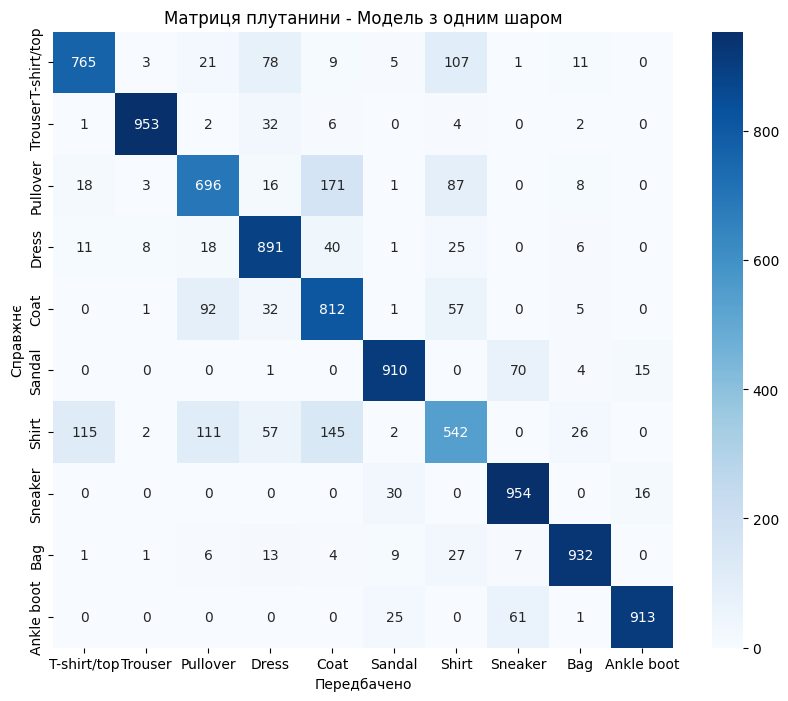

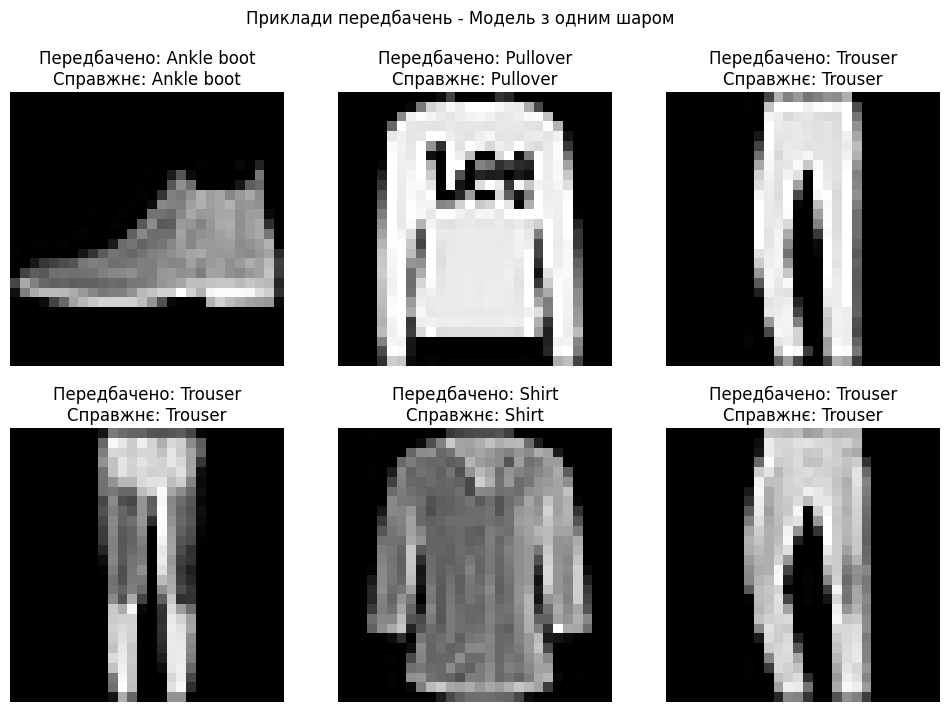

In [13]:
# Відображення метрик для моделі з одним шаром
epochs = range(1, len(loss_one) + 1)
plot_metrics(epochs, loss_one, val_loss_one, acc_one, val_acc_one, 'Модель з одним шаром')

# Матриця плутанини для моделі з одним шаром
plot_confusion_matrix(model_one, test_loader, 'Модель з одним шаром')

# Візуалізація передбачень для моделі з одним шаром
visualize_predictions(model_one, test_loader, 'Модель з одним шаром')

Тренування та оцінка моделі з двома шарами

In [14]:
model_two = TwoLayerNN().to(device)
optimizer = optim.Adam(model_two.parameters(), lr=0.001)

loss_two, val_loss_two, acc_two, val_acc_two = train_model(model_two, criterion, optimizer, train_loader, val_loader)
test_acc_two = evaluate_model(model_two, test_loader)
print(f'Точність на тестовому наборі для моделі з двома шарами: {test_acc_two:.4f}')

Epoch 1/10 - Training: 100%|██████████| 750/750 [00:07<00:00, 102.76it/s]


Epoch 1/10, Train Loss: 0.5202, Train Acc: 0.8149, Val Loss: 0.4207, Val Acc: 0.8478


Epoch 2/10 - Training: 100%|██████████| 750/750 [00:08<00:00, 90.89it/s] 


Epoch 2/10, Train Loss: 0.3942, Train Acc: 0.8577, Val Loss: 0.3790, Val Acc: 0.8619


Epoch 3/10 - Training: 100%|██████████| 750/750 [00:08<00:00, 90.41it/s] 


Epoch 3/10, Train Loss: 0.3561, Train Acc: 0.8715, Val Loss: 0.3755, Val Acc: 0.8654


Epoch 4/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 115.57it/s]


Epoch 4/10, Train Loss: 0.3301, Train Acc: 0.8790, Val Loss: 0.3574, Val Acc: 0.8685


Epoch 5/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 112.78it/s]


Epoch 5/10, Train Loss: 0.3091, Train Acc: 0.8864, Val Loss: 0.3435, Val Acc: 0.8743


Epoch 6/10 - Training: 100%|██████████| 750/750 [00:07<00:00, 94.05it/s] 


Epoch 6/10, Train Loss: 0.2952, Train Acc: 0.8916, Val Loss: 0.3548, Val Acc: 0.8752


Epoch 7/10 - Training: 100%|██████████| 750/750 [00:08<00:00, 91.38it/s] 


Epoch 7/10, Train Loss: 0.2785, Train Acc: 0.8957, Val Loss: 0.3460, Val Acc: 0.8712


Epoch 8/10 - Training: 100%|██████████| 750/750 [00:13<00:00, 56.78it/s] 


Epoch 8/10, Train Loss: 0.2676, Train Acc: 0.8995, Val Loss: 0.3368, Val Acc: 0.8838


Epoch 9/10 - Training: 100%|██████████| 750/750 [00:07<00:00, 96.95it/s] 


Epoch 9/10, Train Loss: 0.2590, Train Acc: 0.9045, Val Loss: 0.3291, Val Acc: 0.8792


Epoch 10/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 116.54it/s]


Epoch 10/10, Train Loss: 0.2489, Train Acc: 0.9064, Val Loss: 0.3261, Val Acc: 0.8829
Точність на тестовому наборі для моделі з двома шарами: 0.8742


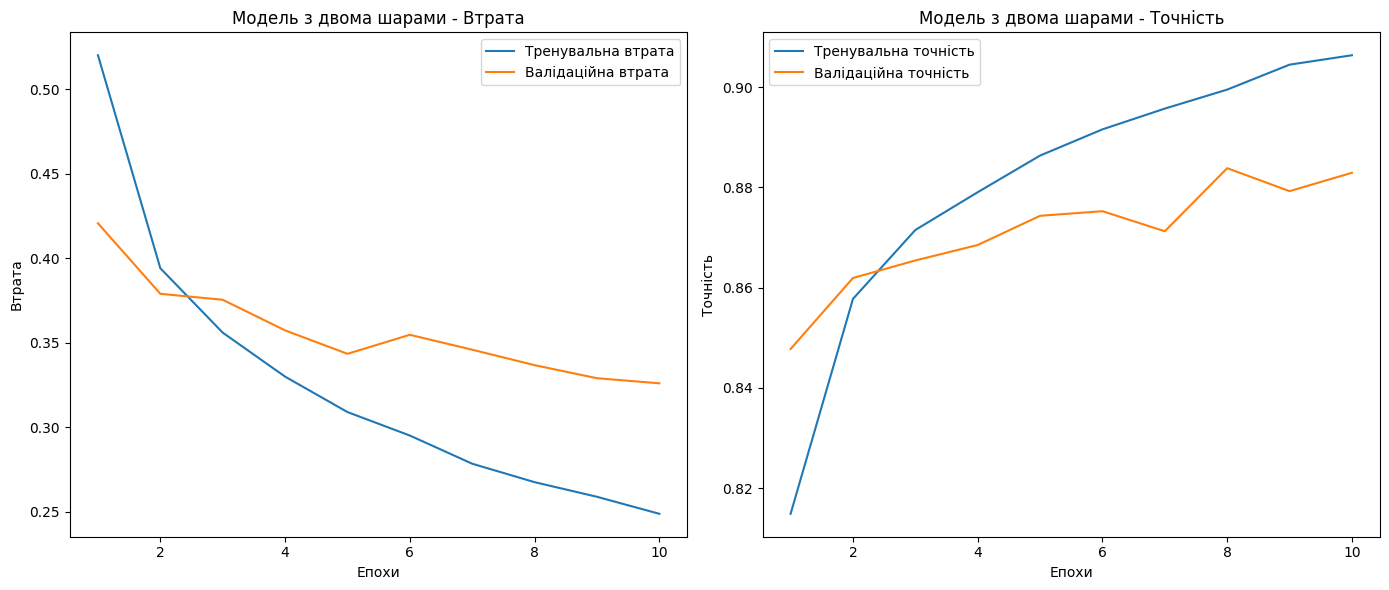

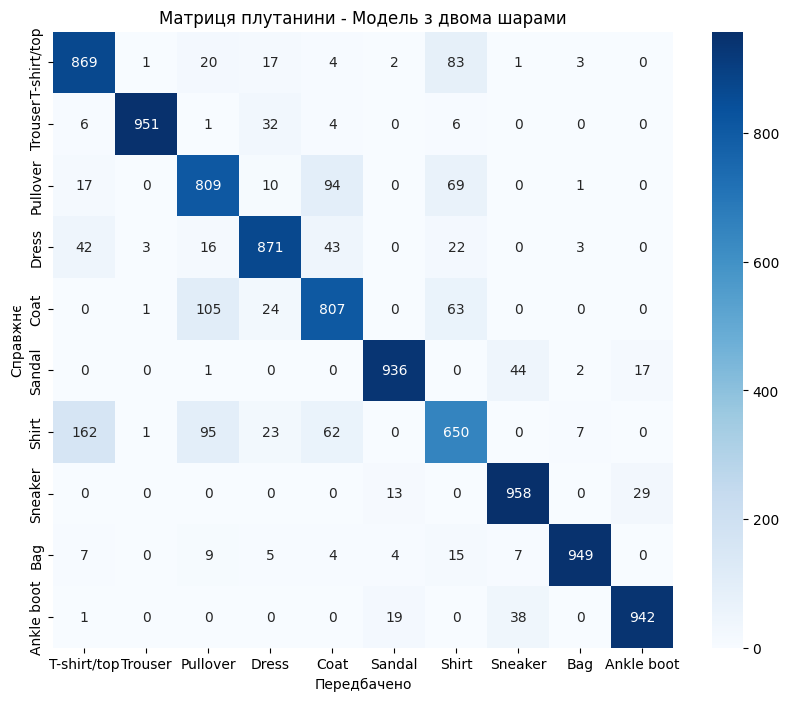

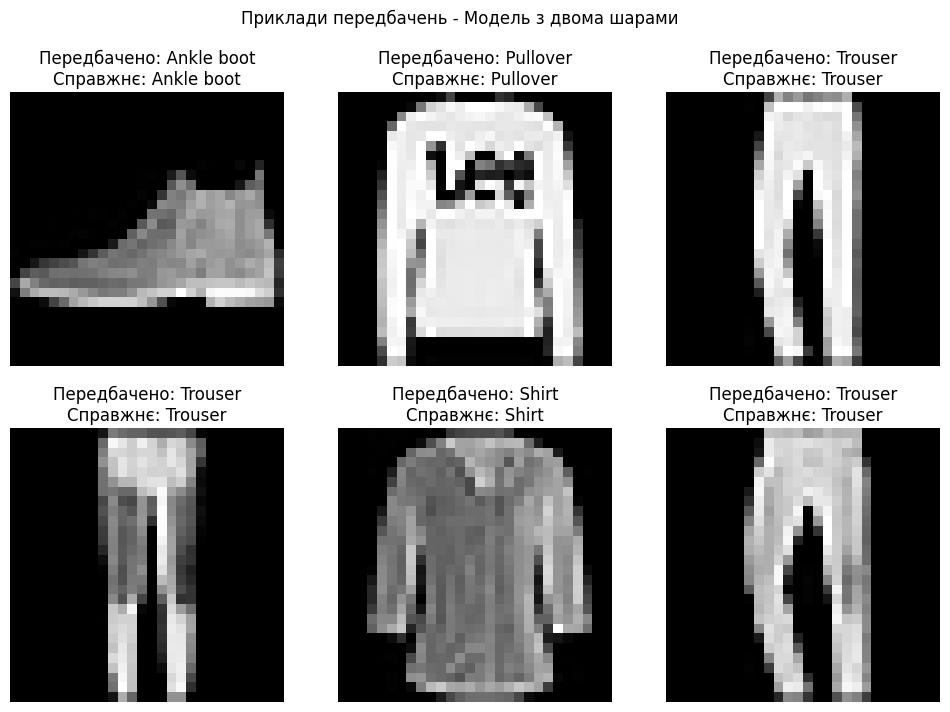

In [15]:
# Відображення метрик для моделі з двома шарами
plot_metrics(epochs, loss_two, val_loss_two, acc_two, val_acc_two, 'Модель з двома шарами')

# Матриця плутанини для моделі з двома шарами
plot_confusion_matrix(model_two, test_loader, 'Модель з двома шарами')

# Візуалізація передбачень для моделі з двома шарами
visualize_predictions(model_two, test_loader, 'Модель з двома шарами')

Тренування та оцінка моделі з трьома шарами

In [16]:
model_three = ThreeLayerNN().to(device)
optimizer = optim.Adam(model_three.parameters(), lr=0.001)

loss_three, val_loss_three, acc_three, val_acc_three = train_model(model_three, criterion, optimizer, train_loader, val_loader)
test_acc_three = evaluate_model(model_three, test_loader)
print(f'Точність на тестовому наборі для моделі з трьома шарами: {test_acc_three:.4f}')

Epoch 1/10 - Training: 100%|██████████| 750/750 [00:09<00:00, 77.89it/s] 


Epoch 1/10, Train Loss: 0.5179, Train Acc: 0.8100, Val Loss: 0.4095, Val Acc: 0.8478


Epoch 2/10 - Training: 100%|██████████| 750/750 [00:07<00:00, 99.34it/s] 


Epoch 2/10, Train Loss: 0.3779, Train Acc: 0.8618, Val Loss: 0.3580, Val Acc: 0.8697


Epoch 3/10 - Training: 100%|██████████| 750/750 [00:07<00:00, 103.12it/s]


Epoch 3/10, Train Loss: 0.3394, Train Acc: 0.8746, Val Loss: 0.3523, Val Acc: 0.8728


Epoch 4/10 - Training: 100%|██████████| 750/750 [00:10<00:00, 71.69it/s] 


Epoch 4/10, Train Loss: 0.3107, Train Acc: 0.8838, Val Loss: 0.3492, Val Acc: 0.8760


Epoch 5/10 - Training: 100%|██████████| 750/750 [00:17<00:00, 42.27it/s]


Epoch 5/10, Train Loss: 0.2956, Train Acc: 0.8904, Val Loss: 0.3517, Val Acc: 0.8726


Epoch 6/10 - Training: 100%|██████████| 750/750 [00:11<00:00, 66.19it/s] 


Epoch 6/10, Train Loss: 0.2753, Train Acc: 0.8967, Val Loss: 0.3294, Val Acc: 0.8792


Epoch 7/10 - Training: 100%|██████████| 750/750 [00:11<00:00, 64.16it/s]


Epoch 7/10, Train Loss: 0.2616, Train Acc: 0.9031, Val Loss: 0.3073, Val Acc: 0.8913


Epoch 8/10 - Training: 100%|██████████| 750/750 [00:10<00:00, 68.96it/s]


Epoch 8/10, Train Loss: 0.2482, Train Acc: 0.9063, Val Loss: 0.3161, Val Acc: 0.8869


Epoch 9/10 - Training: 100%|██████████| 750/750 [00:09<00:00, 75.01it/s]


Epoch 9/10, Train Loss: 0.2360, Train Acc: 0.9109, Val Loss: 0.3229, Val Acc: 0.8839


Epoch 10/10 - Training: 100%|██████████| 750/750 [00:10<00:00, 74.59it/s]


Epoch 10/10, Train Loss: 0.2245, Train Acc: 0.9158, Val Loss: 0.3321, Val Acc: 0.8852
Точність на тестовому наборі для моделі з трьома шарами: 0.8776


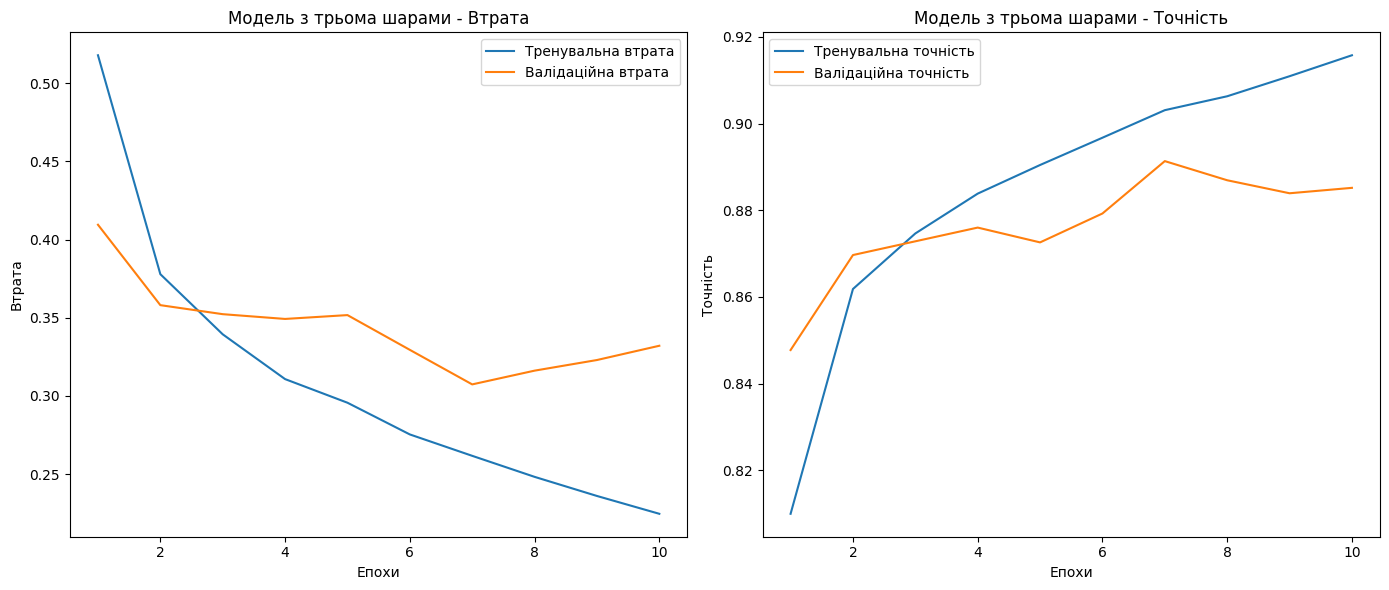

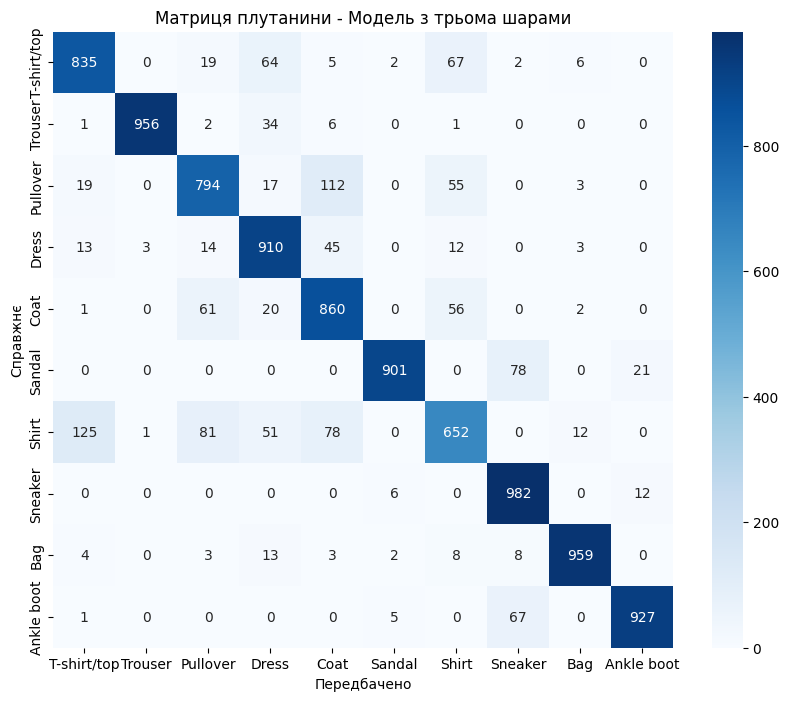

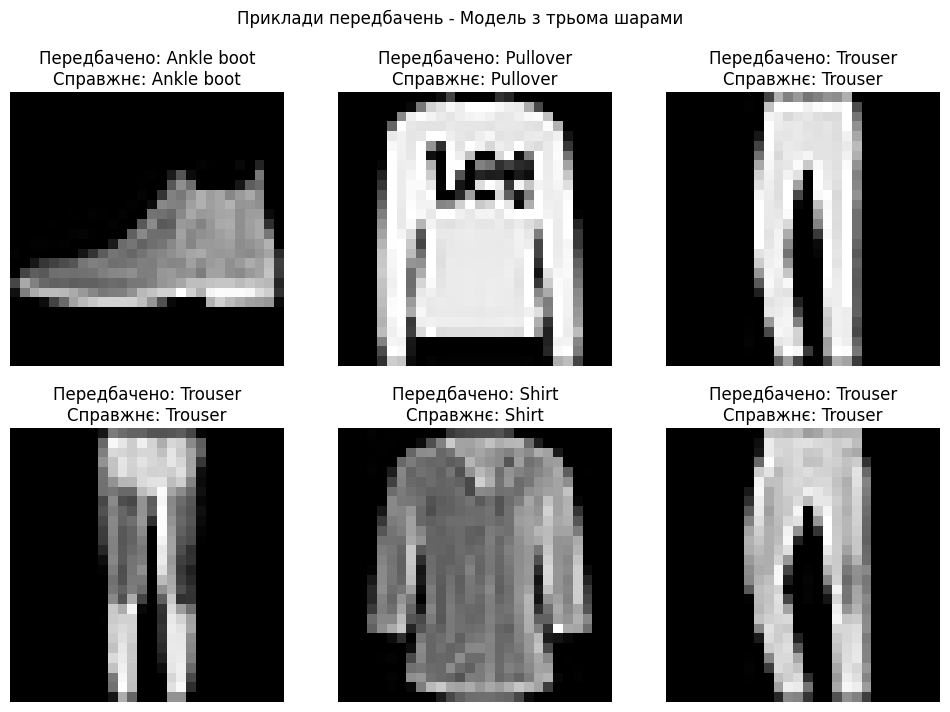

In [17]:
# Відображення метрик для моделі з трьома шарами
plot_metrics(epochs, loss_three, val_loss_three, acc_three, val_acc_three, 'Модель з трьома шарами')

# Матриця плутанини для моделі з трьома шарами
plot_confusion_matrix(model_three, test_loader, 'Модель з трьома шарами')

# Візуалізація передбачень для моделі з трьома шарами
visualize_predictions(model_three, test_loader, 'Модель з трьома шарами')

Тренування та оцінка CNN моделі

In [18]:
model_cnn = CNN().to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

loss_cnn, val_loss_cnn, acc_cnn, val_acc_cnn = train_model(model_cnn, criterion, optimizer, train_loader, val_loader)
test_acc_cnn = evaluate_model(model_cnn, test_loader)
print(f'Точність на тестовому наборі для CNN моделі: {test_acc_cnn:.4f}')

Epoch 1/10 - Training: 100%|██████████| 750/750 [08:19<00:00,  1.50it/s]


Epoch 1/10, Train Loss: 0.4182, Train Acc: 0.8509, Val Loss: 0.2811, Val Acc: 0.9015


Epoch 2/10 - Training: 100%|██████████| 750/750 [04:09<00:00,  3.01it/s]


Epoch 2/10, Train Loss: 0.2862, Train Acc: 0.8962, Val Loss: 0.2386, Val Acc: 0.9142


Epoch 3/10 - Training: 100%|██████████| 750/750 [03:10<00:00,  3.93it/s]


Epoch 3/10, Train Loss: 0.2502, Train Acc: 0.9096, Val Loss: 0.2318, Val Acc: 0.9167


Epoch 4/10 - Training: 100%|██████████| 750/750 [04:27<00:00,  2.80it/s]


Epoch 4/10, Train Loss: 0.2286, Train Acc: 0.9174, Val Loss: 0.2294, Val Acc: 0.9232


Epoch 5/10 - Training: 100%|██████████| 750/750 [04:17<00:00,  2.92it/s]


Epoch 5/10, Train Loss: 0.2113, Train Acc: 0.9225, Val Loss: 0.2574, Val Acc: 0.9252


Epoch 6/10 - Training: 100%|██████████| 750/750 [02:24<00:00,  5.18it/s]


Epoch 6/10, Train Loss: 0.2166, Train Acc: 0.9211, Val Loss: 0.1990, Val Acc: 0.9311


Epoch 7/10 - Training: 100%|██████████| 750/750 [00:13<00:00, 55.58it/s]


Epoch 7/10, Train Loss: 0.1911, Train Acc: 0.9310, Val Loss: 0.1944, Val Acc: 0.9330


Epoch 8/10 - Training: 100%|██████████| 750/750 [00:13<00:00, 55.74it/s]


Epoch 8/10, Train Loss: 0.1758, Train Acc: 0.9368, Val Loss: 0.2494, Val Acc: 0.9290


Epoch 9/10 - Training: 100%|██████████| 750/750 [00:13<00:00, 55.08it/s]


Epoch 9/10, Train Loss: 0.1641, Train Acc: 0.9391, Val Loss: 0.1986, Val Acc: 0.9337


Epoch 10/10 - Training: 100%|██████████| 750/750 [03:43<00:00,  3.35it/s]


Epoch 10/10, Train Loss: 0.1644, Train Acc: 0.9394, Val Loss: 0.2013, Val Acc: 0.9325
Точність на тестовому наборі для CNN моделі: 0.9252


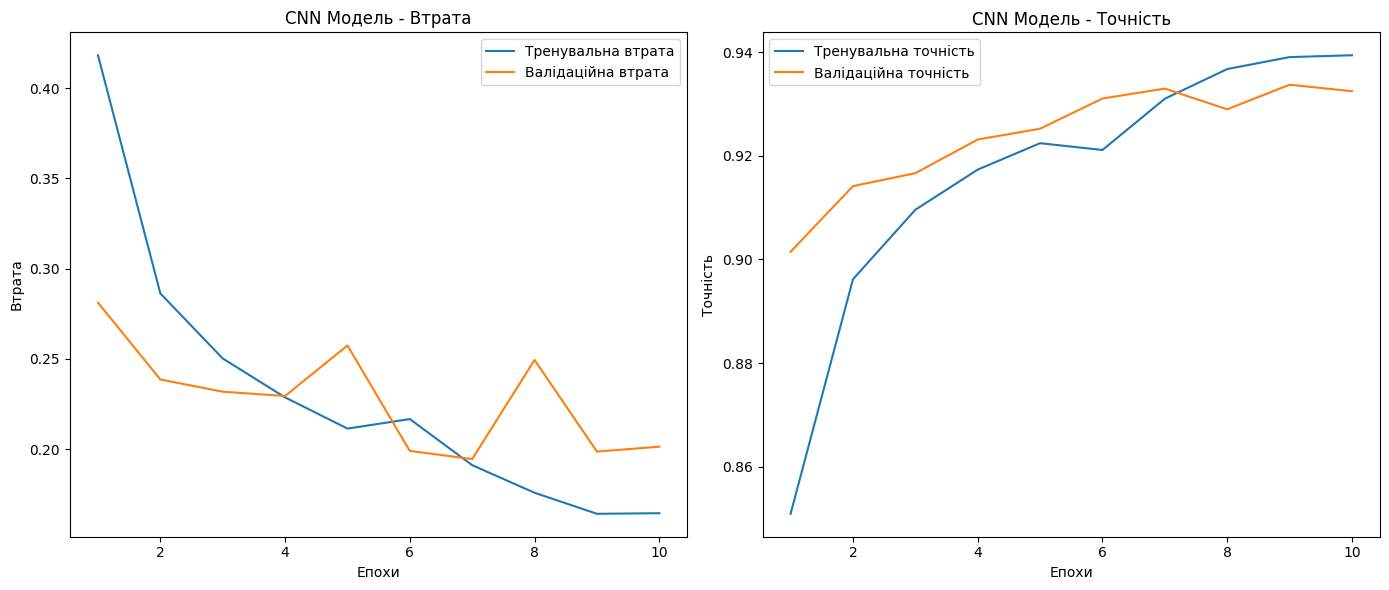

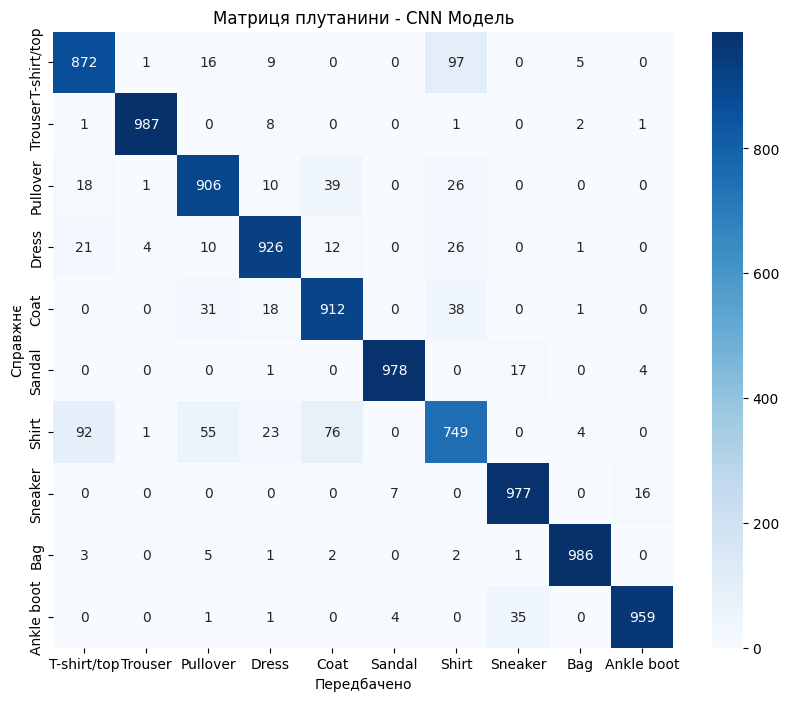

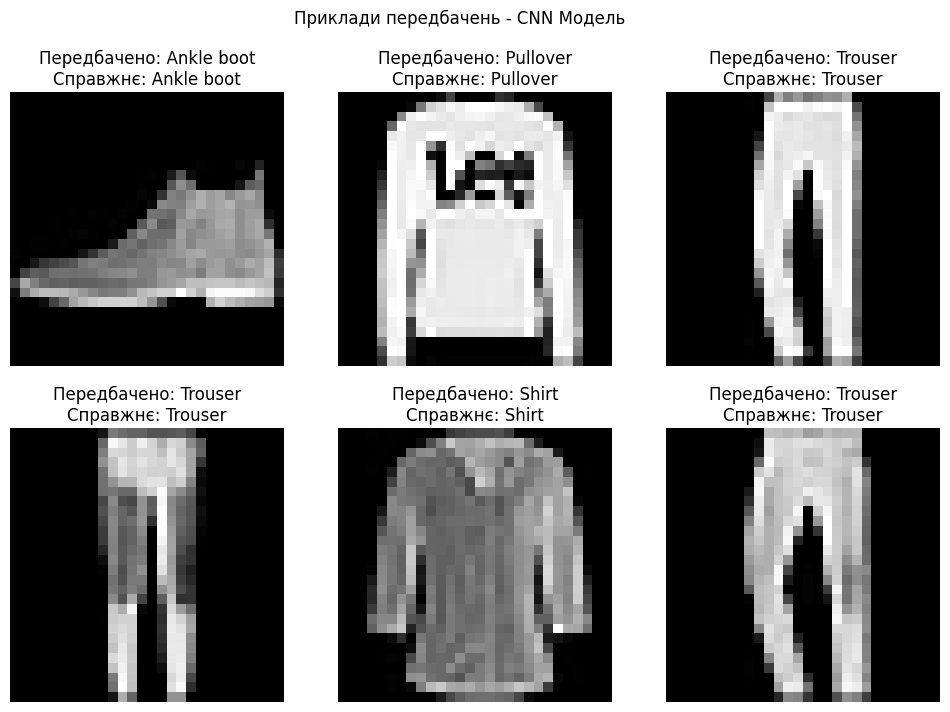

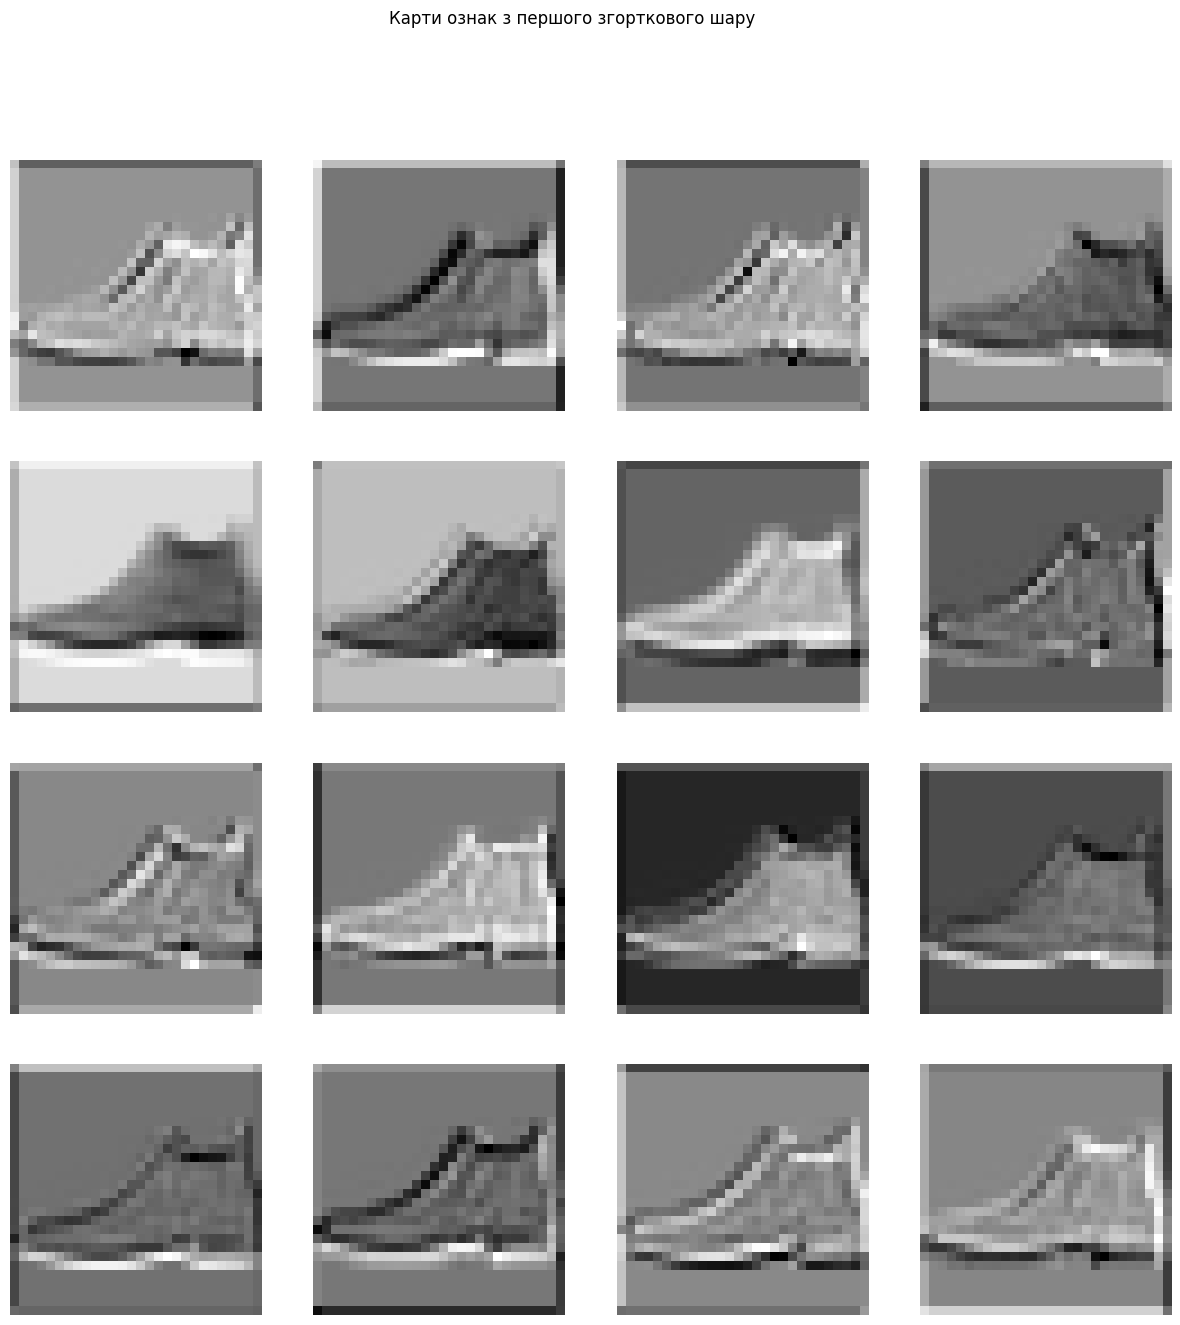

In [19]:
# Відображення метрик для CNN моделі
plot_metrics(epochs, loss_cnn, val_loss_cnn, acc_cnn, val_acc_cnn, 'CNN Модель')

# Матриця плутанини для CNN моделі
plot_confusion_matrix(model_cnn, test_loader, 'CNN Модель')

# Візуалізація передбачень для CNN моделі
visualize_predictions(model_cnn, test_loader, 'CNN Модель')

# Візуалізація карт ознак для CNN моделі
visualize_feature_maps(model_cnn, test_loader)

Тренування та оцінка моделі з двома шарами та сигмоїдальною активацією

In [20]:
model_two_sigmoid = TwoLayerSigmoidNN().to(device)
optimizer = optim.Adam(model_two_sigmoid.parameters(), lr=0.001)

loss_two_sigmoid, val_loss_two_sigmoid, acc_two_sigmoid, val_acc_two_sigmoid = train_model(model_two_sigmoid, criterion, optimizer, train_loader, val_loader)
test_acc_two_sigmoid = evaluate_model(model_two_sigmoid, test_loader)
print(f'Точність на тестовому наборі для моделі з двома шарами та сигмоїдальною активацією: {test_acc_two_sigmoid:.4f}')

Epoch 1/10 - Training: 100%|██████████| 750/750 [00:12<00:00, 58.88it/s]


Epoch 1/10, Train Loss: 0.6142, Train Acc: 0.7953, Val Loss: 0.4359, Val Acc: 0.8475


Epoch 2/10 - Training: 100%|██████████| 750/750 [00:33<00:00, 22.59it/s] 


Epoch 2/10, Train Loss: 0.4152, Train Acc: 0.8515, Val Loss: 0.3918, Val Acc: 0.8600


Epoch 3/10 - Training: 100%|██████████| 750/750 [00:24<00:00, 31.20it/s] 


Epoch 3/10, Train Loss: 0.3718, Train Acc: 0.8672, Val Loss: 0.3687, Val Acc: 0.8664


Epoch 4/10 - Training: 100%|██████████| 750/750 [00:24<00:00, 31.19it/s] 


Epoch 4/10, Train Loss: 0.3458, Train Acc: 0.8756, Val Loss: 0.3641, Val Acc: 0.8700


Epoch 5/10 - Training: 100%|██████████| 750/750 [00:23<00:00, 31.36it/s] 


Epoch 5/10, Train Loss: 0.3258, Train Acc: 0.8820, Val Loss: 0.3435, Val Acc: 0.8769


Epoch 6/10 - Training: 100%|██████████| 750/750 [00:09<00:00, 76.72it/s] 


Epoch 6/10, Train Loss: 0.3099, Train Acc: 0.8895, Val Loss: 0.3326, Val Acc: 0.8817


Epoch 7/10 - Training: 100%|██████████| 750/750 [00:04<00:00, 184.99it/s]


Epoch 7/10, Train Loss: 0.2964, Train Acc: 0.8932, Val Loss: 0.3270, Val Acc: 0.8832


Epoch 8/10 - Training: 100%|██████████| 750/750 [00:04<00:00, 180.97it/s]


Epoch 8/10, Train Loss: 0.2843, Train Acc: 0.8980, Val Loss: 0.3209, Val Acc: 0.8831


Epoch 9/10 - Training: 100%|██████████| 750/750 [00:04<00:00, 184.61it/s]


Epoch 9/10, Train Loss: 0.2717, Train Acc: 0.9018, Val Loss: 0.3184, Val Acc: 0.8863


Epoch 10/10 - Training: 100%|██████████| 750/750 [00:03<00:00, 188.49it/s]


Epoch 10/10, Train Loss: 0.2620, Train Acc: 0.9056, Val Loss: 0.3138, Val Acc: 0.8868
Точність на тестовому наборі для моделі з двома шарами та сигмоїдальною активацією: 0.8763


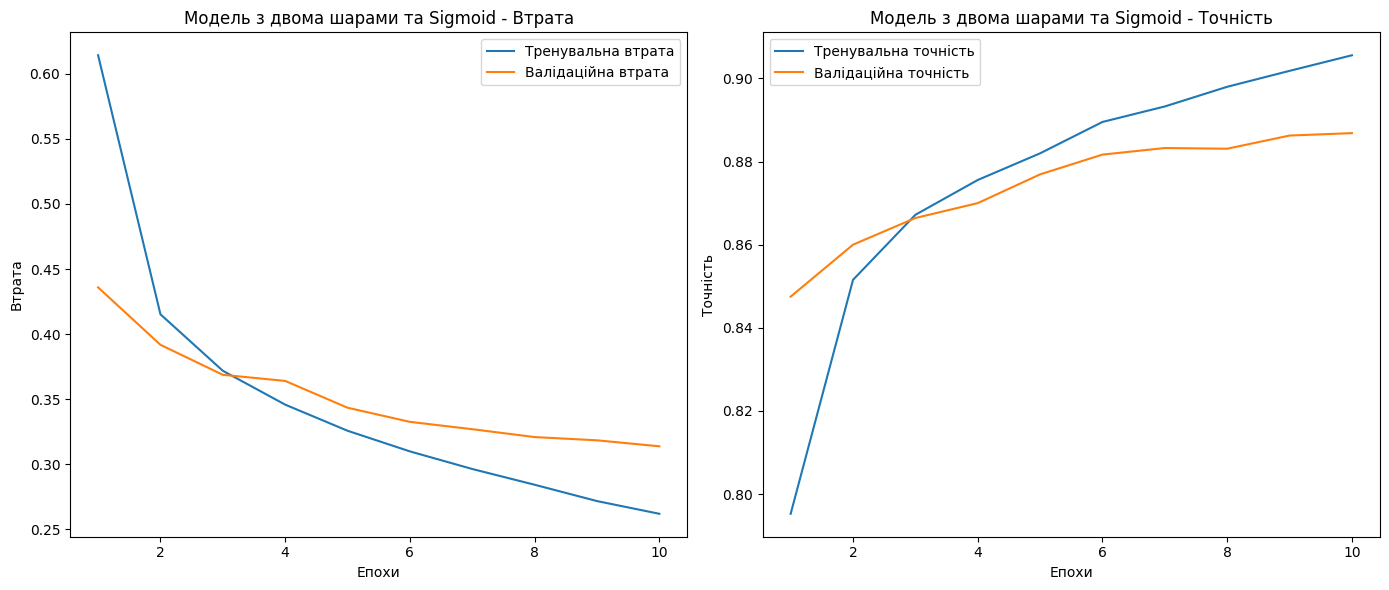

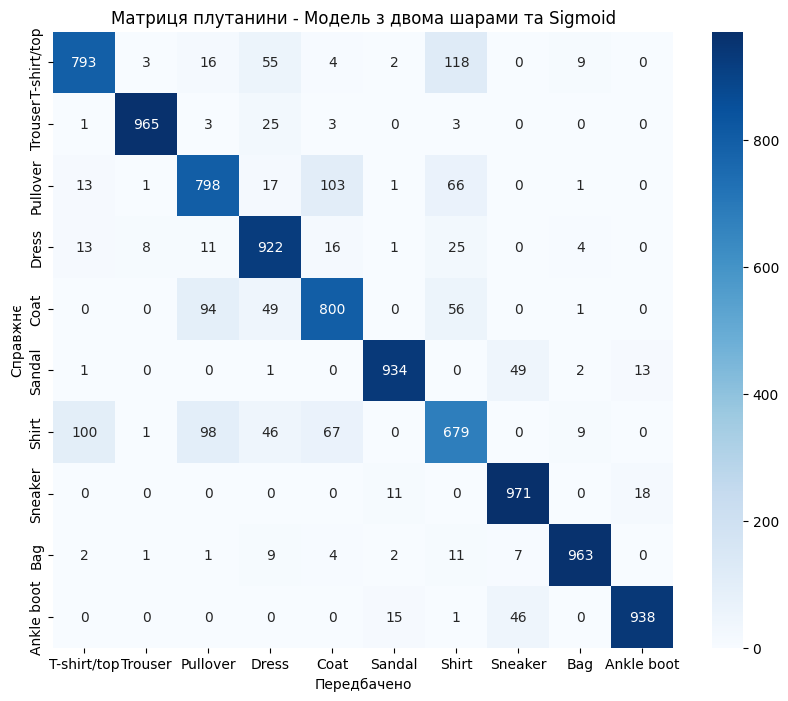

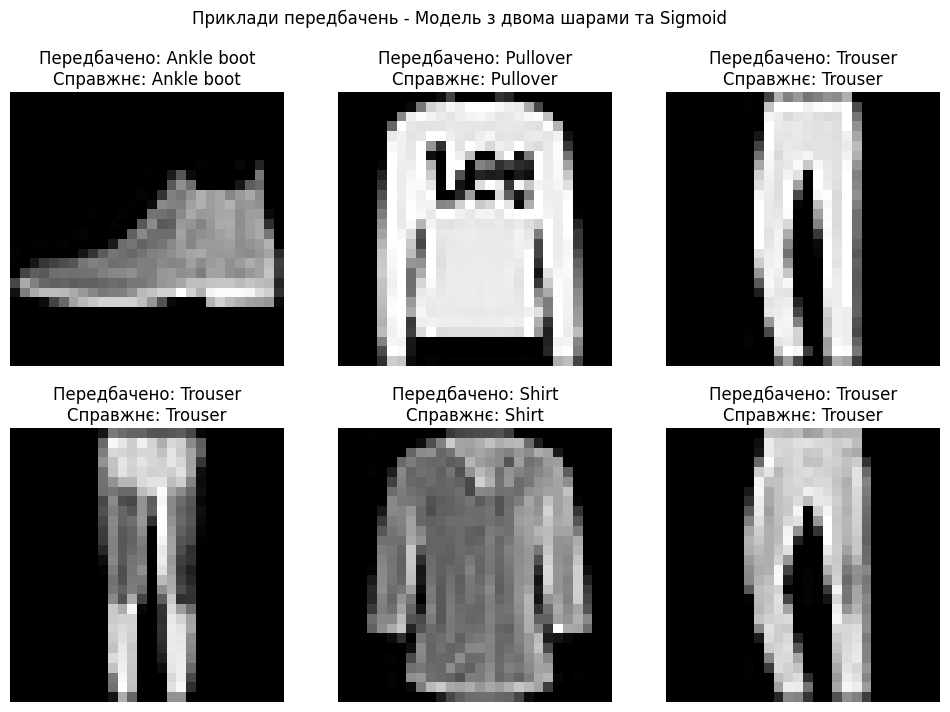

In [21]:
# Відображення метрик для моделі з двома шарами та сигмоїдальною активацією
plot_metrics(epochs, loss_two_sigmoid, val_loss_two_sigmoid, acc_two_sigmoid, val_acc_two_sigmoid, 'Модель з двома шарами та Sigmoid')

# Матриця плутанини для моделі з двома шарами та сигмоїдальною активацією
plot_confusion_matrix(model_two_sigmoid, test_loader, 'Модель з двома шарами та Sigmoid')

# Візуалізація передбачень для моделі з двома шарами та сигмоїдальною активацією
visualize_predictions(model_two_sigmoid, test_loader, 'Модель з двома шарами та Sigmoid')

Побудова графіків тренувальної втрати та точності

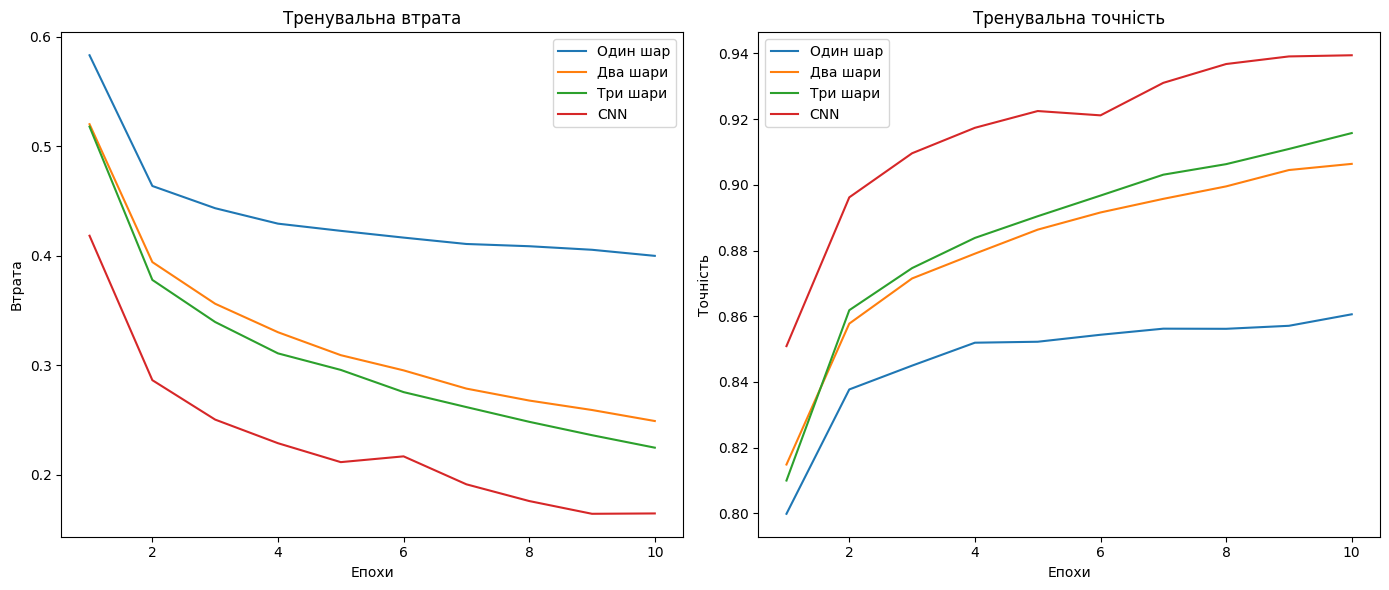

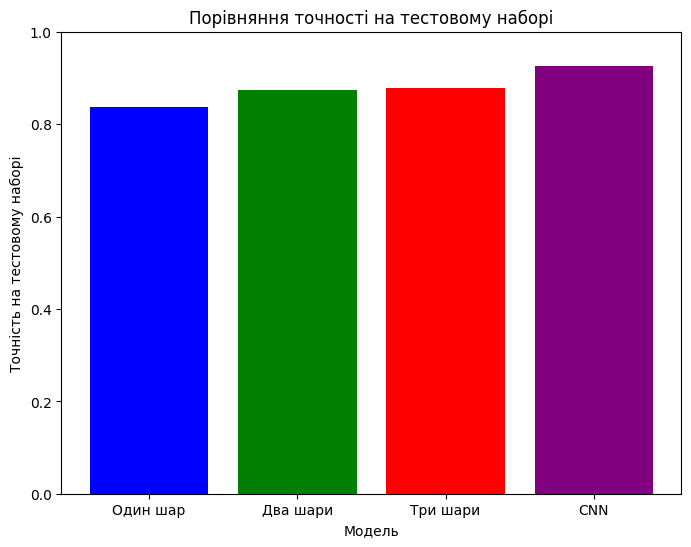

In [22]:
epochs = range(1, 11)

# Графік тренувальної втрати
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_one, label='Один шар')
plt.plot(epochs, loss_two, label='Два шари')
plt.plot(epochs, loss_three, label='Три шари')
plt.plot(epochs, loss_cnn, label='CNN')
plt.xlabel('Епохи')
plt.ylabel('Втрата')
plt.title('Тренувальна втрата')
plt.legend()

# Графік тренувальної точності
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_one, label='Один шар')
plt.plot(epochs, acc_two, label='Два шари')
plt.plot(epochs, acc_three, label='Три шари')
plt.plot(epochs, acc_cnn, label='CNN')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.title('Тренувальна точність')
plt.legend()

plt.tight_layout()
plt.show()

# Побудова графіку точності на тестовому наборі
models = ['Один шар', 'Два шари', 'Три шари', 'CNN']
test_accuracies = [test_acc_one, test_acc_two, test_acc_three, test_acc_cnn]

plt.figure(figsize=(8, 6))
plt.bar(models, test_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Модель')
plt.ylabel('Точність на тестовому наборі')
plt.title('Порівняння точності на тестовому наборі')
plt.ylim(0, 1)
plt.show()